In [535]:
import requests
import pandas as pd
import numpy as np
import statsmodels as sm
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
from statsmodels.tsa.stattools import kpss, adfuller
%matplotlib inline

In [536]:
def get_coinbase_price_history( start_date="1/1/2020",end_date ="3/1/2020",
                    crypto="BTC-USD",granularity=86400):

    rest_api_str = f'https://api.pro.coinbase.com/products/{crypto}/candles?start="{start_date}"&end="{end_date}"&granularity={granularity}'
    
    response = requests.get(rest_api_str)
    data = pd.DataFrame(response.json())
    data = data.rename({0:"date", 4:"price"}, axis=1)
    data = data.iloc[:,[0, 4]]
    data["date"] = pd.to_datetime(data["date"], unit='s') # convert timestamp to date
    
    data.set_index("date", inplace=True)
    data.sort_index(inplace=True)
    return data
    

In [537]:
data = None

ether_file = Path("ether_data.obj")

if ether_file.is_file(): # if file exist, do not hit API
    file = open(ether_file,'rb')
    data = pickle.load(file)
    file.close()
else: # else, read API data and save it in pickle object

    year_1 = pd.concat(
        [
            get_coinbase_price_history(start_date="9/21/2017",end_date ="12/20/2017",crypto="ETH-USD"),
            get_coinbase_price_history(start_date="12/21/2017",end_date ="3/20/2018",crypto="ETH-USD"),
            get_coinbase_price_history(start_date="3/21/2018",end_date ="6/20/2018",crypto="ETH-USD"),
            get_coinbase_price_history(start_date="6/21/2018",end_date ="9/20/2018",crypto="ETH-USD")
        ]
                )


    year_2 = pd.concat(
        [
            get_coinbase_price_history(start_date="9/21/2018",end_date ="12/20/2018",crypto="ETH-USD"),
            get_coinbase_price_history(start_date="12/21/2018",end_date ="3/20/2019",crypto="ETH-USD"),
            get_coinbase_price_history(start_date="3/21/2019",end_date ="6/20/2019",crypto="ETH-USD"),
            get_coinbase_price_history(start_date="6/21/2019",end_date ="9/20/2019",crypto="ETH-USD")
        ]
                )

    year_3 = pd.concat(
        [
            get_coinbase_price_history(start_date="9/21/2019",end_date ="12/20/2019",crypto="ETH-USD"),
            get_coinbase_price_history(start_date="12/21/2019",end_date ="3/20/2020",crypto="ETH-USD"),
            get_coinbase_price_history(start_date="3/21/2020",end_date ="6/20/2020",crypto="ETH-USD"),
            get_coinbase_price_history(start_date="6/21/2020",end_date ="9/20/2020",crypto="ETH-USD")
        ]
                )

    year_4 = pd.concat(
        [
            get_coinbase_price_history(start_date="9/21/2020",end_date ="12/20/2020",crypto="ETH-USD"),
            get_coinbase_price_history(start_date="12/21/2020",end_date ="3/20/2021",crypto="ETH-USD"),
            get_coinbase_price_history(start_date="3/21/2021",end_date ="6/20/2021",crypto="ETH-USD"),
            get_coinbase_price_history(start_date="6/21/2021",end_date ="9/22/2021",crypto="ETH-USD")
        ]
                )

    data = pd.concat([year_1, year_2, year_3, year_4])
    
    filehandler = open(ether_file,"wb")
    pickle.dump(data,filehandler)
    filehandler.close()

data

,price
date,
2017-09-21,258.11
2017-09-22,263.88
2017-09-23,286.03
2017-09-24,283.21
2017-09-25,294.41
...,...
2021-09-18,3436.31
2021-09-19,3328.59
2021-09-20,2976.48


In [538]:
data.shape

(1463, 1)

In [539]:
#monthly_data = data.resample("W").last()

In [679]:
data_sample = data["2019":"2021"]

In [680]:
data_sample = np.log(data_sample)

In [681]:
data_sample.tail()

,price
date,
2021-09-18,8.142154
2021-09-19,8.110304
2021-09-20,7.998497
2021-09-21,7.925045
2021-09-22,8.032061


# Does it look Stationary?

- Stationary - A constant variance and mean over time

- We can determine this more efficiently with a **Unit Root Test**, covered later
    - If a series contains a unit root, it is not stationary and difficult to predict
    - Most financial data is not stationary

- If not stationary, we simply take the difference until it is stationary

<AxesSubplot:xlabel='date'>

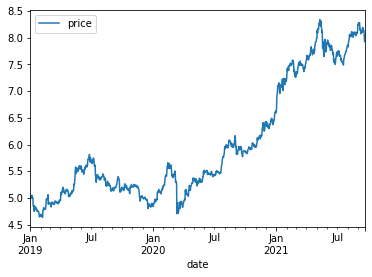

In [682]:
data_sample.plot()

### Difference the data

- Looks more stationary, still need **Unit Root Test** to confirm

<AxesSubplot:xlabel='date'>

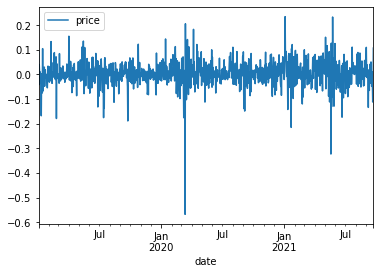

In [683]:
d1_data = data_sample.copy().diff().dropna()
d1_data.plot()

In [684]:
d1_data.head()

,price
date,
2019-01-02,0.093845
2019-01-03,-0.041705
2019-01-04,0.040009
2019-01-05,0.006310
2019-01-06,0.011028


In [685]:
adfuller(d1_data["price"])

(-9.446385813844186,
 4.743202058450781e-16,
 9,
 985,
 {'1%': -3.4370062675076807,
  '5%': -2.8644787205542492,
  '10%': -2.568334722615888},
 -2974.6122781301465)

https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/ 
^^ Adapted code from

You want KPSS stat to be smaller than critical value

In [686]:

from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        if "5%" == key:
            print(f'   {key} : {value}')
            print(f'Result: The series is {"not " if statistic >= value else ""}stationary')

kpss_test(d1_data["price"], regression="c", nlags="auto") # regression="ct" to test for trend too

KPSS Statistic: 0.1932882315753177
p-value: 0.1
num lags: 7
Critial Values:
   5% : 0.463
Result: The series is stationary


/Users/dan/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [687]:
#statsmodels.graphics.tsaplots.plot_acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Reading ACF plot

- We want to make sure there is AutoCorrelation before we build an ARIMA model, otherwise the data is White Noise, and can not be predicted!

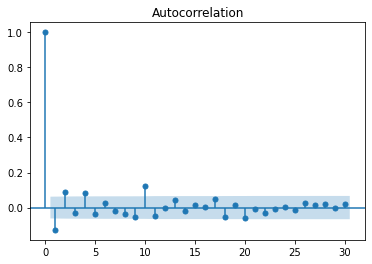

In [688]:
acf = plot_acf(d1_data["price"])

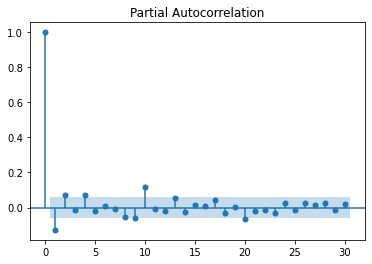

In [689]:
pacf = plot_pacf(d1_data["price"])

In [690]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox


In [691]:
data_sample_months = data_sample.copy()
data_sample_months["month"] = data_sample_months.index.month
months_dummies = pd.get_dummies(data_sample_months, columns=['month'])
months_dummies.drop(columns=[ "price"], inplace=True)
data_sample_months = pd.concat([data_sample, months_dummies], axis=1)
data_sample_months

,price,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
2019-01-01,4.939855,1,0,0,0,0,0,0,0,0,0,0,0
2019-01-02,5.033701,1,0,0,0,0,0,0,0,0,0,0,0
2019-01-03,4.991996,1,0,0,0,0,0,0,0,0,0,0,0
2019-01-04,5.032005,1,0,0,0,0,0,0,0,0,0,0,0
2019-01-05,5.038315,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-18,8.142154,0,0,0,0,0,0,0,0,1,0,0,0
2021-09-19,8.110304,0,0,0,0,0,0,0,0,1,0,0,0
2021-09-20,7.998497,0,0,0,0,0,0,0,0,1,0,0,0


In [692]:
model = ARIMA(data_sample_months["price"],
              #data_sample_months.drop(columns=["price", "month_6", "month_4", "month_3", "month_8", 
                  #                             "month_10", "month_5", "month_1", "month_12", "month_11", "month_2", "month_7"]), 
              order=(
    [1,10], 1, [2,4]), freq="D")
#res = model.fit()

/Users/dan/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [693]:
res = model.fit()

In [694]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                         price   No. Observations:                  996
Model:             ARIMA([1, 10], 1, [2, 4])   Log Likelihood                1529.318
Date:                       Wed, 22 Sep 2021   AIC                          -3048.635
Time:                               17:10:51   BIC                          -3024.122
Sample:                           01-01-2019   HQIC                         -3039.316
                                - 09-22-2021                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1074      0.023     -4.667      0.000      -0.152      -0.062
ar.L10         0.1279      0.032      3.945      0.000       0.064       0.191
ma.L2          0.0767      0.031      2.475      0.013       0.016       0.137
ma.L4          0.0875      0.027      3.240      0.001       0.035       0.140
sigma2         0.0027   5.93e-05     45.670      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11562.58
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

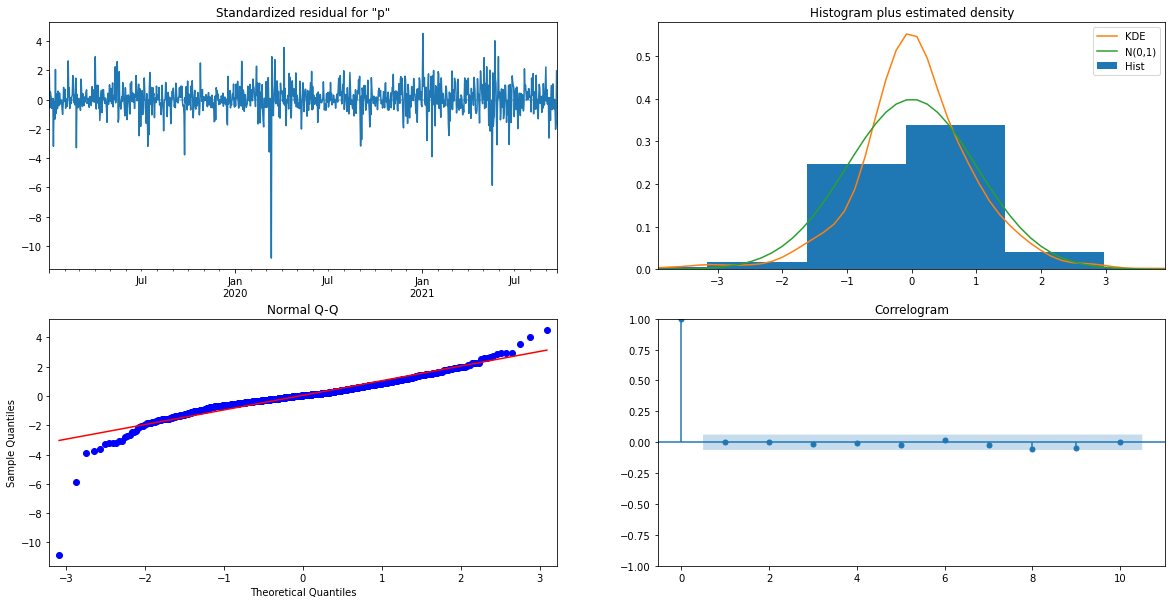

In [695]:
diag_plots = res.plot_diagnostics(figsize=(20,10))

## for Ljung Box test we want the p-values to be above 5%

In [696]:
acorr_ljungbox(res.resid, lags=[4,8,12,16], model_df=7, return_df=True)

,lb_stat,lb_pvalue
4,0.329191,NaN
8,0.415423,0.519230
12,1.888661,0.864327
16,2.610880,0.977751


## Fitted Values (Predictions) vs Actual

<AxesSubplot:xlabel='date'>

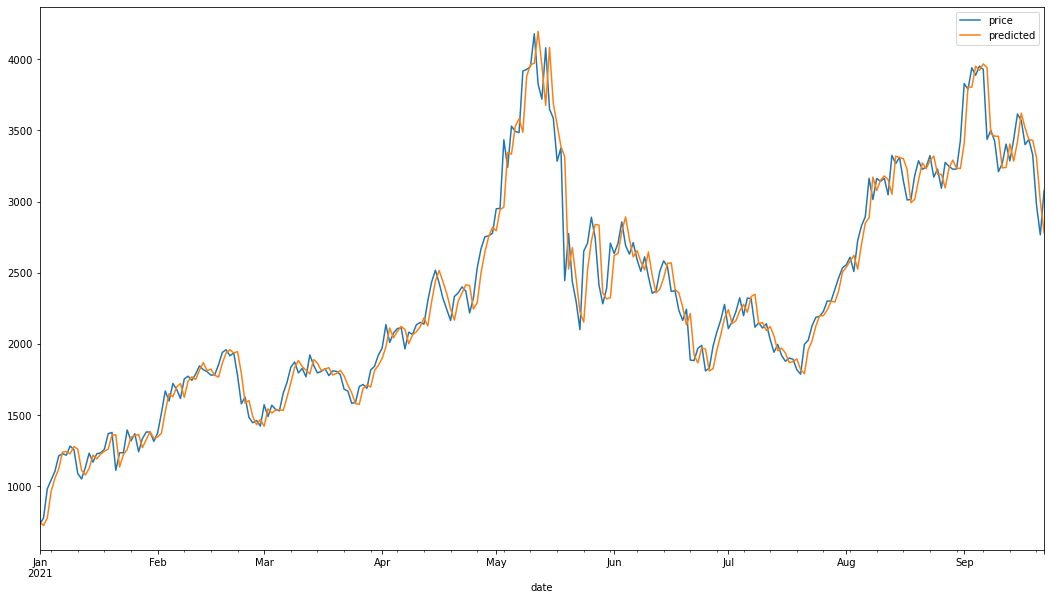

In [697]:
y = data_sample.copy()
y["predicted"] = res.fittedvalues
y = np.exp(y)
y.loc["2021"].plot(figsize=(18,10))

In [698]:
forecast = res.get_forecast(15)
yhat = np.exp(forecast.predicted_mean)
yhat_conf_int = np.exp(forecast.conf_int(alpha=0.05))

In [699]:
yhat

2021-09-23    3002.237143
2021-09-24    3023.215062
2021-09-25    3018.821368
2021-09-26    3041.256296
2021-09-27    3020.085680
2021-09-28    3026.459965
2021-09-29    3013.477998
2021-09-30    2972.076129
2021-10-01    2948.671845
2021-10-02    2991.835253
2021-10-03    2977.656214
2021-10-04    2981.829243
2021-10-05    2980.826464
2021-10-06    2983.757546
2021-10-07    2980.779110
Freq: D, Name: predicted_mean, dtype: float64

In [700]:
yhat_conf_int

,lower price,upper price
2021-09-23,2711.229095,3324.480355
2021-09-24,2637.038228,3465.944943
2021-09-25,2548.544492,3575.877322
2021-09-26,2499.507506,3700.424918
2021-09-27,2414.074298,3778.225684
2021-09-28,2361.125744,3879.276630
2021-09-29,2299.485746,3949.165442
2021-09-30,2221.946582,3975.449541
2021-10-01,2162.701409,4020.280197
2021-10-02,2155.199379,4153.248312


In [701]:

#y["predictions"] = yhat
#y["lower_ci"] = yhat_conf_int.iloc[:,0]
#y["upper_ci"] = yhat_conf_int.iloc[:,1]
#y.tail()

In [702]:
y

,price,predicted
date,,
2019-01-01,139.75,1.000000
2019-01-02,153.50,139.750000
2019-01-03,147.23,151.807174
2019-01-04,153.24,149.043348
2019-01-05,154.21,152.058606
...,...,...
2021-09-18,3436.31,3435.467200
2021-09-19,3328.59,3430.587511
2021-09-20,2976.48,3308.219102


<AxesSubplot:xlabel='date'>

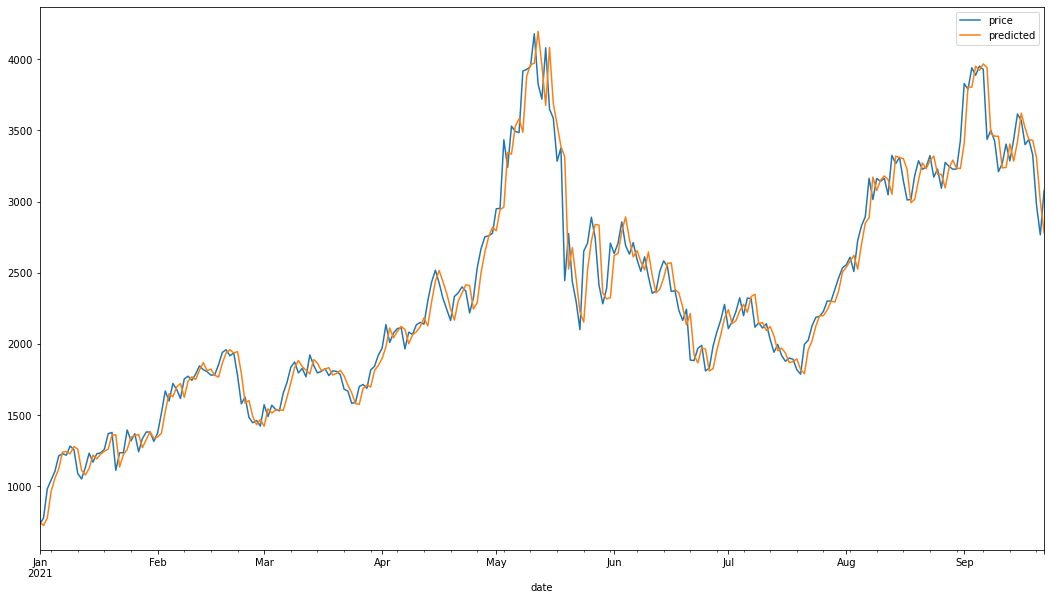

In [703]:
y.loc["2021"].plot(figsize=(18,10))

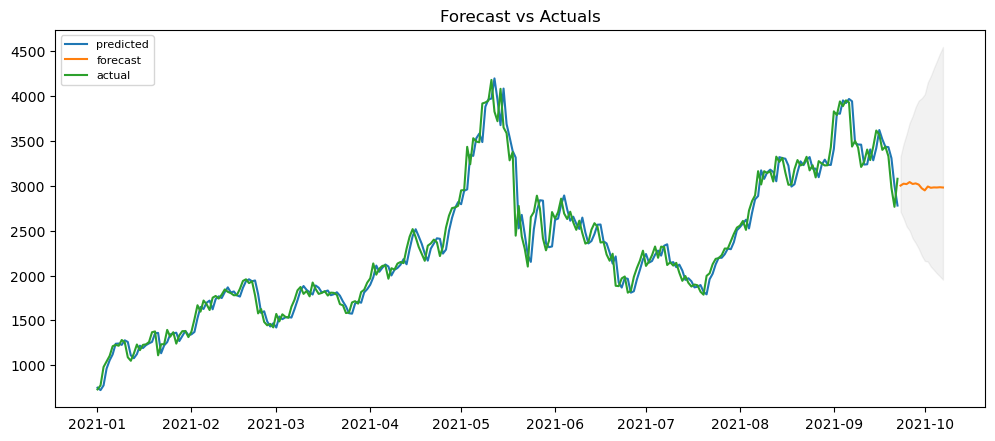

In [704]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y["predicted"].loc["2021"], label='predicted')
plt.plot(yhat, label='forecast')
plt.plot(y["price"].loc["2021"], label='actual')
plt.fill_between(yhat_conf_int.index, yhat_conf_int.iloc[:,0], yhat_conf_int.iloc[:,1], 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [705]:
from arch import arch_model

In [706]:
np.exp(data_sample)

,price
date,
2019-01-01,139.75
2019-01-02,153.50
2019-01-03,147.23
2019-01-04,153.24
2019-01-05,154.21
...,...
2021-09-18,3436.31
2021-09-19,3328.59
2021-09-20,2976.48


In [711]:
model = arch_model(np.exp(data_sample["price"]).values, mean="Zero", vol="GARCH", p=1, q=1, rescale=True)
res = model.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2809.35
Distribution:                  Normal   AIC:                           5624.70
Method:            Maximum Likelihood   BIC:                           5639.41
                                        No. Observations:                  996
Date:                Wed, Sep 22 2021   Df Residuals:                      996
Time:                        17:11:24   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0237  1.411e-02      1.680  9.295e-02 [-3.949e-03,5.134e-02]
alpha[1]       0.8888  3.011e-02     29.519 1.642e-191      [  0.830,  0.948]
beta[1]        0.1112  3.101e-02      3.586  3.363e-04    [5.041e-02,  0.172]
=============================================================================

Covariance estimator: robust
"""

In [725]:
# Construct Volatility Forecasts for the next 3 days
forecast_horizon = 15
# Take the last day of the data we used above. 
# If forecast horizon is 3, then the resulting 'h.1', 'h.2', and 'h.3' 
# are the forecasts for the following 3 days.
forecasts = res.forecast( horizon=forecast_horizon, reindex=False)
forecasts

intermediate = np.sqrt(forecasts.variance.dropna() * 365.25)
vol_forecast = intermediate.melt()

In [726]:
#vol_forecast.drop(columns=["variable"])
vol_forecast["upper"] = yhat.values + vol_forecast["value"]
vol_forecast["lower"] = yhat.values - vol_forecast["value"]

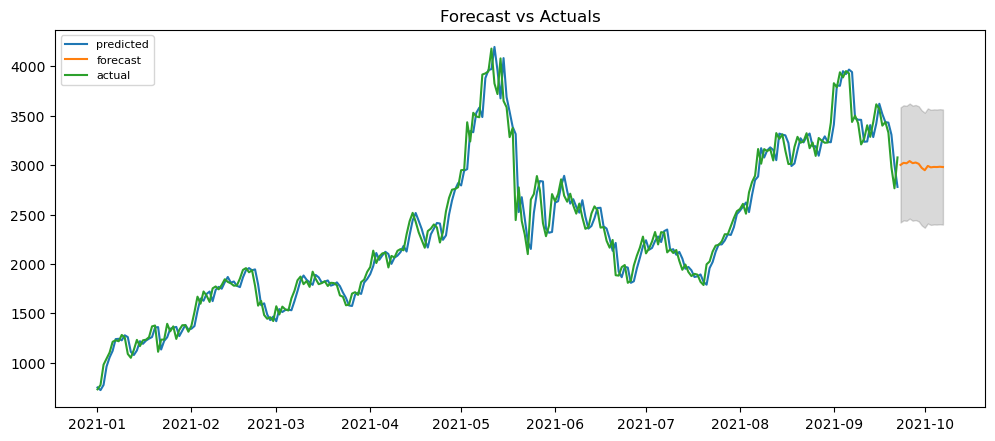

In [727]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y["predicted"].loc["2021"], label='predicted')
plt.plot(yhat, label='forecast')
plt.plot(y["price"].loc["2021"], label='actual')
plt.fill_between(yhat_conf_int.index, vol_forecast["lower"], vol_forecast["upper"], 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()